In [1]:
import gym
import random
from collections import deque

In [2]:
import numpy as np

#tf.config.set_visible_devices([], 'GPU')
    
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

import math

In [3]:
#needed for visualizing on the display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:

from IPython import display as ipythondisplay
from string import Formatter

def display_model(model):
    tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
    return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []
    def append(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def get(self):
        return self.loss

class PeriodicPlotter:
    def __init__(self, xlabel='', ylabel='', scale=None):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.scale = scale
    def plot(self, data):
        plt.cla()

        if self.scale is None:
            plt.plot(data)
        elif self.scale == 'semilogx':
            plt.semilogx(data)
        elif self.scale == 'semilogy':
            plt.semilogy(data)
        elif self.scale == 'loglog':
            plt.loglog(data)
        else:
            raise ValueError("unrecognized parameter scale {}".format(self.scale))

        plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

In [5]:
import functools
import time


def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

class DQNAgent:
    def __init__(self, state_size, action_size, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 1e-3
        self._build_model()
        
    def _build_model(self):
        n = 24
        model = keras.Sequential()
        model.add(layers.Dense(n, input_dim=self.state_size, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
        model.add(layers.Dense(n, activation='relu',activity_regularizer=regularizers.l2(1e-3)))
        model.add(layers.Dense(self.action_size, activation='linear',activity_regularizer=regularizers.l2(1e-3)))
        model.compile(loss="mse", optimizer= optimizers.Adam(lr=self.learning_rate))
        self.model = model
        
        
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            act_values = self.model.predict(state)
            return np.argmax(act_values[0])
        
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states, targets  = [], []
        for state, action ,reward, next_state, done in minibatch:
            target = reward
            if not done:
                prediction = self.model.predict(next_state)[0]
                target = reward + self.gamma * \
                         np.amax(prediction)
            target_f = self.model.predict(state)
            if math.isnan(target_f[0][0]):
                print("Target_f nan")
                raise Exception("target is nan")
            target_f[0][action] = target
            states.append(state)
            targets.append(target_f)
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_weights(self, name):
        print(f"saving weights in {weights_file}")
        self.model.save_weights(name)

    def load_weights(self, name):
        print(f"loading weights from {weights_file}")
        self.model.load_weights(name)

In [6]:
 # initialize gym environment and the agent


In [7]:
done = False
batch_size = 128

In [8]:
EPISODES = 1000

In [9]:
def run_step(env, action):
    return env.step(action)

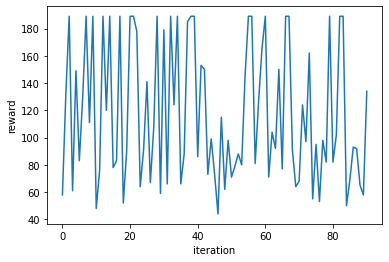

saving weights in weights
episode 91/1000, score: 68, e: 0.01
episode 92/1000, score: 123, e: 0.01
episode 93/1000, score: 199, e: 0.01
episode 94/1000, score: 119, e: 0.01
episode 95/1000, score: 58, e: 0.01
episode 96/1000, score: 99, e: 0.01
episode 97/1000, score: 73, e: 0.01


KeyboardInterrupt: 

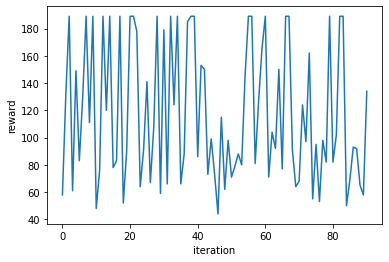

In [10]:
load_weights = True
weights_file = "weights"
rewards = []
plotter = PeriodicPlotter(xlabel='iteration', ylabel='reward')
with gym.make('CartPole-v0') as env:
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size, epsilon = 0.01)
    if load_weights:
        agent.load_weights(weights_file)
    
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, (1,state_size))
        
        episode_reward = 0
        for t in range(500):
            #show_state(img, env, t)
            #env.render()
            action = agent.act(state)
            next_state, reward, done, _ = run_step(env,action)
            reward = reward if not done else -10
            episode_reward += reward
            next_state = np.reshape(next_state, [1,state_size])
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"episode {e}/{EPISODES}, score: {t}, e: {agent.epsilon:.2}")
                rewards.append(episode_reward)
                break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10 == 0 and e > 0:
            plotter.plot(rewards)
            agent.save_weights(weights_file)